If additional cations are included, they may be included as (screened) Coulomb interactions with additional LJ/Buckingham potentials.
ref: https://pubs.rsc.org/en/Content/ArticleLanding/2011/CP/c1cp21034c

Solubility of CO2 is approximately 1g/kg H2O at 300 K, so there is approximately 2500 water molecules per molecule of CO2.

In [17]:
%pylab notebook
%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
from itertools import product

from ase import Atoms, units
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.io import write
from ase.neighborlist import neighbor_list
from ase.build import *
from ase.md import *

homepath = "D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\"
homepath

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


D:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'sort', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


'D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\'

In [18]:
H2O_bulk = molecule('H2O')

box_length = ((125 / (55.5 * cst.Avogadro)) * (1e+27))**(1 / 3)

H2O_bulk.set_cell((box_length, box_length, box_length))
H2O_bulk.center()

H2O_bulk = H2O_bulk.repeat((5, 5, 5))
H2O_bulk.rattle(stdev=0.01)
H2O_bulk.set_pbc(True)

view(H2O_bulk, viewer='ngl')

In [9]:
# H2O configuration ref: http://www.wag.caltech.edu/home/duin/Reax/ReaxFF_HCO_JPCA.pdf
H2O_bulk_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 1.008",
             "2 15.999"],
    "velocity": ["all create 300.0 4928459 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.oh' + ' H O'],
    "neighbor": "2.0 bin",
    "neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "5000",
    "timestep": 0.1,
    "fix": ["1 all qeq/reax 1 0.0 10.0 1e-6 reax/c",
            "2 all temp/berendsen 300.0 300.0 100"]
}

In [10]:
# Setting up simulation input
H2O_bulk_calc = LAMMPS(tmp_dir = homepath + "temp", 
                       parameters = H2O_bulk_reaxff_params,
                       keep_tmp_files=True, no_data_file=True)
H2O_bulk.set_calculator(H2O_bulk_calc)
H2O_bulk_calc.atoms = H2O_bulk.copy()
H2O_bulk_calc.prism = Prism(H2O_bulk_calc.atoms.get_cell())

In [11]:
# Writing input file
H2O_bulk_calc.write_lammps_in(lammps_in = homepath + "co2_hydration\\H2O_bulk_reaxff.in",
                              lammps_trj = homepath + "co2_hydration\\H2O_bulk_reaxff.lammpstrj")

In [ ]:
# Running calculations
!lmp_serial -in co2_hydration\H2O_bulk_reaxff.in -log co2_hydration\H2O_bulk_reaxff.log

In [12]:
# Reading LAMMPS output
H2O_bulk_calc.read_lammps_log(lammps_log = homepath + "co2_hydration\\H2O_bulk_reaxff.log")
H2O_bulk_data = H2O_bulk_calc.thermo_content[-1]

H2O_bulk_calc.trajectory_out = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.trj", 'w')
H2O_bulk_calc.read_lammps_trj(lammps_trj = homepath + "co2_hydration\\H2O_bulk_reaxff.lammpstrj")

In [14]:
H2O_bulk_trj = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.trj")

In [16]:
view(H2O_bulk_trj, viewer='ngl')

In [63]:
H2O_bulk_trj = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.trj")
H2O_bulk_trj_view = view(H2O_bulk_trj, viewer='ngl')
H2O_bulk_trj_view.view.update_spacefill(radiusType='covalent',
                                        scale=0.8,
                                        color_scheme='element',
                                        color_scale='rainbow')
H2O_bulk_trj_view.view.player.step = 10
H2O_bulk_trj_view

In [8]:
H2O_last = H2O_bulk_trj[-1]

In [9]:
H2O_bulk_trj[0][[a.index for a in H2O_bulk_trj[0] if a.symbol == 'O']]

Atoms(symbols='O125', pbc=False, cell=[77.61137502964763, 77.61137502964763, 77.61137502964763], momenta=...)

In [19]:
H2O_bulk_trj_pos = []

for i in range(0, 100000, 1000):
    O_atoms = H2O_bulk_trj[i][[a.index for a in H2O_bulk_trj[i] if a.symbol == 'O']]
    O_pos = O_atoms.positions
    H2O_bulk_trj_pos.append(O_pos)
    
H2O_bulk_trj_pos = array(H2O_bulk_trj_pos)
H2O_bulk_trj_pos_plot = H2O_bulk_trj_pos.transpose(1, 2, 0)

<IPython.core.display.Javascript object>


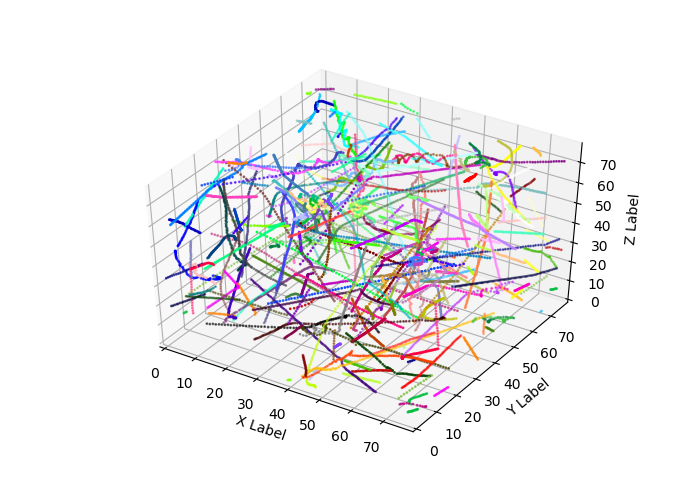

In [29]:
fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

C = linspace(0, 255, 5)
C_list = array([list(x) for x in product(C, C, C)])/255

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for img in H2O_bulk_trj_pos:
    ax.scatter(img[:,0], img[:,1], img[:,2], c=C_list, s=1)

    
plt.show()

<IPython.core.display.Javascript object>


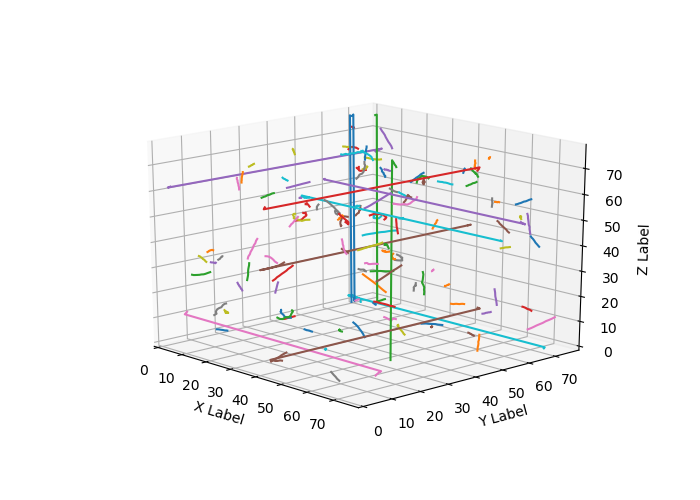

In [16]:
fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for a in H2O_bulk_trj_pos_plot:
    ax.plot(a[0], a[1], a[2])

plt.show()

In [45]:
neighbor_list('i', H2O_bulk_trj[0], 1.85, self_interaction=True)

array([  0,   0,   0, ..., 374, 374, 374])

In [40]:
neighbor_list('i', H2O_last, 1.85, self_interaction=True)

array([  0,   0,   0, ..., 374, 374, 374])